# Assignment 2:  Implicit Neural Representation

Name: 

UID:  

Link to Google Drive :

Please submit a PDF containing all outputs to gradescope by **October 31, 11:59pm**

----------------------------

In this assignment, you will get some hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

In [ ]:
# from google.colab import drive
# from google.colab.patches import cv2_imshow
# drive.mount('/content/drive')
# filepath=r'/content/drive/MyDrive/image.jpg'
filepath= r'./image.jpg'

Using CUDA
cuda:0


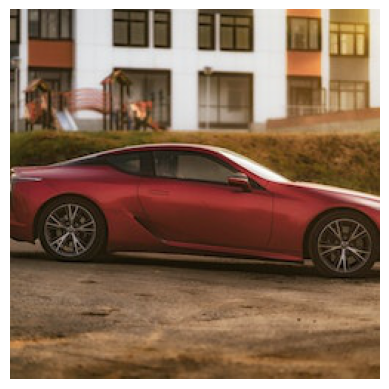

In [ ]:
from torchvision.io import read_image  ## Note: feel free to use another loader
import matplotlib.pyplot as plt
import torch

if torch.cuda.is_available():
    print("Using CUDA")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

image = read_image(filepath)
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()
plt.close()

### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [ ]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        self.image = read_image(img_path)
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        # return
        num_pixels= self.h*self.w
        return num_pixels

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values
        # x =
        # y =
        # intensity =
        x,y=divmod(idx, self.w)
        intensity = self.image[:, y, x]

        return {"x": x, "y": y, "intensity": intensity}

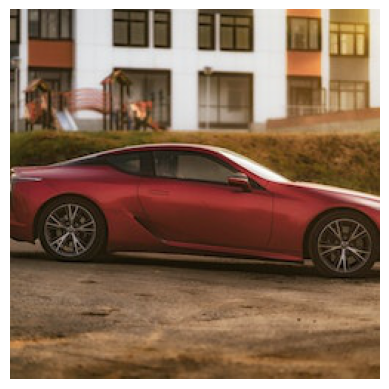

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = SingleImageDataset(filepath)
batch_size=512
### TODO: 1 line of code for initializing a DataLoader
# dataloader =
dataloader = DataLoader(dataset,shuffle=True,pin_memory=False,batch_size=batch_size)
### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image
# some_image =
some_image = torch.zeros((dataset.h, dataset.w, dataset.num_channels), dtype=torch.uint8)
for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    some_image[y,x] = intensity
    # some_image[.....] =

plt.imshow(some_image)
plt.axis('off')
plt.show()

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [ ]:
import torch.nn as nn
class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        # self.layers =
        self.layers = nn.Sequential(
        nn.Linear(2,2048),
         nn.ReLU(),
         nn.Linear(2048,1024),
         nn.ReLU(),
        nn.Linear(1024,1024),
         nn.ReLU(),
         nn.Linear(1024,3)
         )

    def forward(self, coord):
        out = self.layers(coord)
        return out


## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [ ]:
from tqdm import tqdm

# net = FFN()
net = FFN().to(device=device)
# since we are training the network for pixels,
# we will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

loss_avg=0
loss_list=[]

### TODO: 2 lines of code for optimizer, number of epochs
# optimizer = torch.optim.?(?, ?, ?)
# NUM_EPOCHS = ?
optimizer = torch.optim.Adam(net.parameters(), lr=4e-3)
NUM_EPOCHS = 100
### TODO: set up mechanism for storing loss values
# for _ in tqdm(range(NUM_EPOCHS)):
for i in range(NUM_EPOCHS):
  print("EPOCH",i)
  loop = tqdm(dataloader, total=len(dataloader), leave=True)
  loss_avg=0
  for batch in loop:
  # for batch in dataloader:
      x, y, actual = batch["x"], batch["y"], batch["intensity"]
      # x, y, actual = batch["x"].to(device=device), batch["y"].to(device=device), batch["intensity"].to(device=device)
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1
      ### TODO: 3 lines of code to assemble coord from x and y, pass to net,
      ###       compute loss
      #coord =
      #pred =
      #loss =
      coord=torch.stack((x,y),dim=1).to(device)
      pred =net(coord)
      pred=pred.cpu()
      loss = criterion(pred.float(), actual.float())
      # loss_list.append((loss.item()))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_avg= loss_avg+ loss.item()

      ### TODO: track loss
  net_loss= loss_avg/len(dataloader)
  print("\n Net Loss Per Epoch",net_loss)
  loss_list.append(net_loss)

EPOCH 0


 35%|████████████████████████████▎                                                    | 43/123 [00:00<00:00, 213.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 216.04it/s]



 Net Loss Per Epoch 2763.356499896786
EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 215.45it/s]



 Net Loss Per Epoch 2086.7929022564153
EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 191.48it/s]



 Net Loss Per Epoch 1952.1238368584857
EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 215.14it/s]



 Net Loss Per Epoch 1783.4068762306276
EPOCH 4


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.07it/s]



 Net Loss Per Epoch 1633.541017609883
EPOCH 5


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 215.15it/s]



 Net Loss Per Epoch 1519.572012552401
EPOCH 6


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 215.32it/s]



 Net Loss Per Epoch 1427.1649973799542
EPOCH 7


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.64it/s]



 Net Loss Per Epoch 1280.5593638846544
EPOCH 8


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 215.24it/s]



 Net Loss Per Epoch 1213.317077140498
EPOCH 9


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.97it/s]



 Net Loss Per Epoch 1111.3574938270135
EPOCH 10


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 191.08it/s]



 Net Loss Per Epoch 1020.294739265752
EPOCH 11


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.95it/s]



 Net Loss Per Epoch 989.8275201068661
EPOCH 12


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.42it/s]



 Net Loss Per Epoch 955.8654809967289
EPOCH 13


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.94it/s]



 Net Loss Per Epoch 891.1865611502794
EPOCH 14


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.63it/s]



 Net Loss Per Epoch 828.448390557514
EPOCH 15


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 215.19it/s]



 Net Loss Per Epoch 826.6856917714684
EPOCH 16


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.66it/s]



 Net Loss Per Epoch 797.4072141569804
EPOCH 17


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.77it/s]



 Net Loss Per Epoch 762.2127407663237
EPOCH 18


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 191.47it/s]



 Net Loss Per Epoch 730.9764324901549
EPOCH 19


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.74it/s]



 Net Loss Per Epoch 713.4450420596735
EPOCH 20


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.78it/s]



 Net Loss Per Epoch 710.8211295275185
EPOCH 21


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.86it/s]



 Net Loss Per Epoch 639.270717713891
EPOCH 22


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.78it/s]



 Net Loss Per Epoch 661.3582875321551
EPOCH 23


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.68it/s]



 Net Loss Per Epoch 613.9347023072281
EPOCH 24


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.81it/s]



 Net Loss Per Epoch 616.8374742957635
EPOCH 25


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 215.12it/s]



 Net Loss Per Epoch 584.257159969671
EPOCH 26


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 191.12it/s]



 Net Loss Per Epoch 582.8046415995776
EPOCH 27


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.52it/s]



 Net Loss Per Epoch 594.0009589466622
EPOCH 28


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.60it/s]



 Net Loss Per Epoch 556.6597411613154
EPOCH 29


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.55it/s]



 Net Loss Per Epoch 554.0346342257368
EPOCH 30


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.88it/s]



 Net Loss Per Epoch 523.7721986848164
EPOCH 31


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.53it/s]



 Net Loss Per Epoch 530.5543429987217
EPOCH 32


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.57it/s]



 Net Loss Per Epoch 513.7537308359534
EPOCH 33


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.72it/s]



 Net Loss Per Epoch 500.9744562908886
EPOCH 34


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.91it/s]



 Net Loss Per Epoch 506.92221888100227
EPOCH 35


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.63it/s]



 Net Loss Per Epoch 522.4679138679815
EPOCH 36


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.68it/s]



 Net Loss Per Epoch 506.18278366957253
EPOCH 37


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.59it/s]



 Net Loss Per Epoch 472.69888901129
EPOCH 38


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.68it/s]



 Net Loss Per Epoch 480.06153882034425
EPOCH 39


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.70it/s]



 Net Loss Per Epoch 486.4506806164253
EPOCH 40


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.34it/s]



 Net Loss Per Epoch 459.57571882542555
EPOCH 41


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.54it/s]



 Net Loss Per Epoch 454.4367708035601
EPOCH 42


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.99it/s]



 Net Loss Per Epoch 503.53179658719193
EPOCH 43


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.39it/s]



 Net Loss Per Epoch 450.9095064488853
EPOCH 44


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.76it/s]



 Net Loss Per Epoch 439.7191965987043
EPOCH 45


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.60it/s]



 Net Loss Per Epoch 454.3635256387354
EPOCH 46


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.51it/s]



 Net Loss Per Epoch 451.42334430973705
EPOCH 47


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 212.86it/s]



 Net Loss Per Epoch 430.0501021718591
EPOCH 48


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.42it/s]



 Net Loss Per Epoch 442.9730949091717
EPOCH 49


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.68it/s]



 Net Loss Per Epoch 475.52515194280363
EPOCH 50


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.95it/s]



 Net Loss Per Epoch 422.08781073345403
EPOCH 51


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.93it/s]



 Net Loss Per Epoch 437.6583817644817
EPOCH 52


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.18it/s]



 Net Loss Per Epoch 398.26431944312117
EPOCH 53


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.26it/s]



 Net Loss Per Epoch 417.84142594996507
EPOCH 54


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.54it/s]



 Net Loss Per Epoch 406.7697118743648
EPOCH 55


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.19it/s]



 Net Loss Per Epoch 421.80956100836033
EPOCH 56


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.55it/s]



 Net Loss Per Epoch 396.8460378259178
EPOCH 57


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.59it/s]



 Net Loss Per Epoch 417.0010569502668
EPOCH 58


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.39it/s]



 Net Loss Per Epoch 413.12731883971674
EPOCH 59


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.72it/s]



 Net Loss Per Epoch 407.60155207936356
EPOCH 60


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.22it/s]



 Net Loss Per Epoch 396.13296285489713
EPOCH 61


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.84it/s]



 Net Loss Per Epoch 425.8527365583714
EPOCH 62


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.94it/s]



 Net Loss Per Epoch 407.0183132760893
EPOCH 63


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.12it/s]



 Net Loss Per Epoch 394.1703285279313
EPOCH 64


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.46it/s]



 Net Loss Per Epoch 366.5757778756987
EPOCH 65


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.88it/s]



 Net Loss Per Epoch 381.33033367870297
EPOCH 66


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.40it/s]



 Net Loss Per Epoch 363.4573095058038
EPOCH 67


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.36it/s]



 Net Loss Per Epoch 365.9821697948425
EPOCH 68


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.22it/s]



 Net Loss Per Epoch 365.07538635750126
EPOCH 69


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.66it/s]



 Net Loss Per Epoch 365.6975445010798
EPOCH 70


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.19it/s]



 Net Loss Per Epoch 374.83331323639163
EPOCH 71


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.43it/s]



 Net Loss Per Epoch 408.5395536345195
EPOCH 72


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.16it/s]



 Net Loss Per Epoch 359.8056553786363
EPOCH 73


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.81it/s]



 Net Loss Per Epoch 351.53812116917555
EPOCH 74


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.75it/s]



 Net Loss Per Epoch 386.2619807545732
EPOCH 75


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.01it/s]



 Net Loss Per Epoch 391.272455851237
EPOCH 76


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.24it/s]



 Net Loss Per Epoch 340.53067202684355
EPOCH 77


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.08it/s]



 Net Loss Per Epoch 338.73974361264607
EPOCH 78


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.04it/s]



 Net Loss Per Epoch 342.51718536625066
EPOCH 79


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.04it/s]



 Net Loss Per Epoch 374.6282094319661
EPOCH 80


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.03it/s]



 Net Loss Per Epoch 326.43402384936326
EPOCH 81


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.68it/s]



 Net Loss Per Epoch 337.0473268090225
EPOCH 82


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.21it/s]



 Net Loss Per Epoch 343.15027488150247
EPOCH 83


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.50it/s]



 Net Loss Per Epoch 347.8388989456301
EPOCH 84


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.67it/s]



 Net Loss Per Epoch 412.8723572521675
EPOCH 85


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.40it/s]



 Net Loss Per Epoch 341.6756433006225
EPOCH 86


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.54it/s]



 Net Loss Per Epoch 339.6569406152741
EPOCH 87


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.22it/s]



 Net Loss Per Epoch 330.6280918276407
EPOCH 88


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.29it/s]



 Net Loss Per Epoch 325.42441701501366
EPOCH 89


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 189.92it/s]



 Net Loss Per Epoch 370.0603710887878
EPOCH 90


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.43it/s]



 Net Loss Per Epoch 326.25302769110453
EPOCH 91


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.05it/s]



 Net Loss Per Epoch 338.6069710584191
EPOCH 92


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.94it/s]



 Net Loss Per Epoch 342.9166144394293
EPOCH 93


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.51it/s]



 Net Loss Per Epoch 344.57318648671713
EPOCH 94


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.12it/s]



 Net Loss Per Epoch 313.7587778975324
EPOCH 95


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.13it/s]



 Net Loss Per Epoch 305.00658150029375
EPOCH 96


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.25it/s]



 Net Loss Per Epoch 303.62946462243553
EPOCH 97


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 190.75it/s]



 Net Loss Per Epoch 310.44630469345464
EPOCH 98


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.30it/s]



 Net Loss Per Epoch 311.25915601776865
EPOCH 99


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 214.32it/s]


 Net Loss Per Epoch 309.89385403268705


### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

Text(0, 0.5, 'Avg Loss')

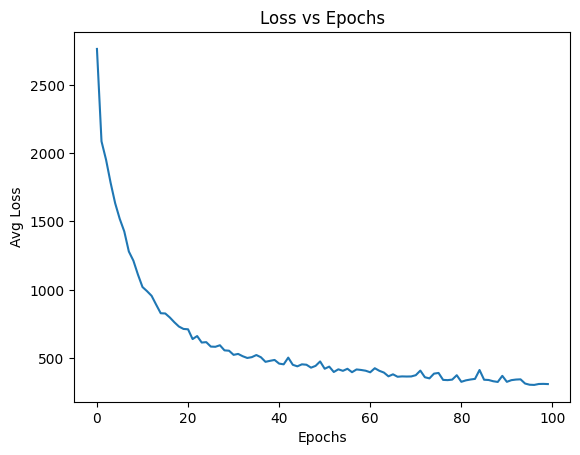

In [ ]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
plt.plot(loss_list)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Avg Loss")

## Evaluation

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

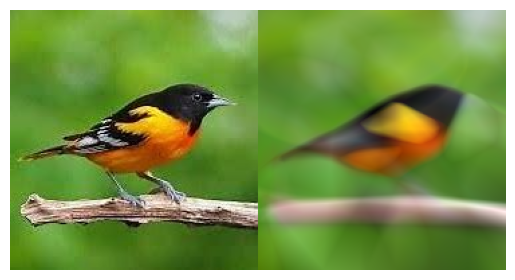

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 289.05it/s]


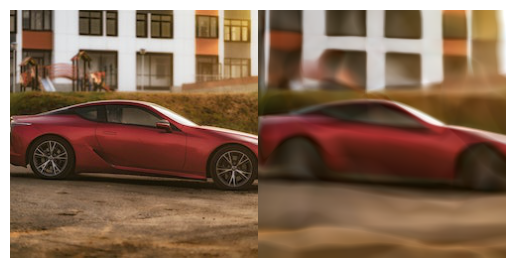

In [ ]:
### TODO: ~12 lines of code to assemble gt_image, build pred_image
###       from model


gt_image= torch.zeros((dataset.h, dataset.w, dataset.num_channels), dtype=torch.uint8)
pred_image= torch.zeros((dataset.h, dataset.w, dataset.num_channels), dtype=torch.uint8)
loop = tqdm(dataloader, total=len(dataloader), leave=True)
for batch in loop:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[y,x] = intensity
    norm_x = x / dataset.w # normalizing x between 0 and 1
    norm_y = y / dataset.h # normalizing y between 0 and 1
    # coord = torch.cat((norm_x, norm_y)).to(device=device)
    coord=torch.stack((norm_x,norm_y),dim=1).to(device=device)
    pred =net(coord).to(device=device)
    pred=pred.detach().cpu()
    pred=torch.clamp(pred,min=0,max=255)
    pred_image[y,x]= pred.to(torch.uint8)

joint_image = torch.cat([gt_image, pred_image], dim=1)
# plt.imshow(joint_image.permute(1, 2, 0))
plt.imshow(joint_image)
plt.axis('off')
plt.show()
plt.close()

### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [ ]:
!pip install  torchmetrics

In [ ]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
from torchmetrics.image import PeakSignalNoiseRatio #https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
psnr = PeakSignalNoiseRatio()
pred_image.shape
pred_tensor= pred_image.permute(2,0,1).unsqueeze(0)
gt_tensor= gt_image.permute(2,0,1).unsqueeze(0)
psnr=psnr(pred_tensor,gt_tensor)
print("\n PSNR",psnr)


 PSNR tensor(29.2672)


### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

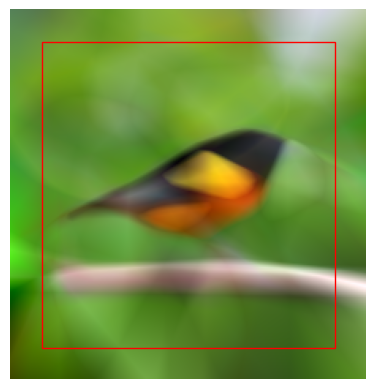

100%|█████████████████████████████████████████████████████████████████████████████████| 290/290 [00:20<00:00, 14.49it/s]


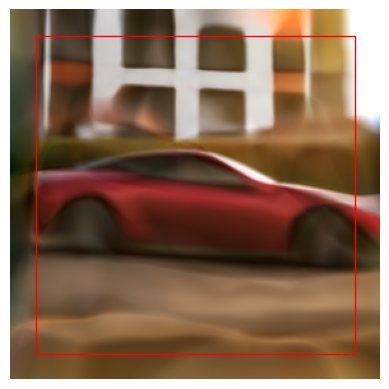

In [ ]:
import matplotlib.patches as patches

### TODO: 6-10 lines of code to generate outpainted image
# outpainted_image =
border=20
sample_image=torch.zeros((dataset.h+border*2, dataset.w+border*2, dataset.num_channels), dtype=torch.uint8)

with torch.no_grad():
    for x in tqdm(range(sample_image.shape[0])):
        for y in range(sample_image.shape[1]):
            if x<250 or x>20 and y>20 or y<250:
                x1=(x-20)/250
                y1=(y-20)/250
            coord=torch.tensor((x1,y1)).to(device=device).to(torch.float32)
            pred =net(coord).to(device=device)
            pred=pred.detach().cpu()
            pred=torch.clamp(pred,min=0,max=255)
            sample_image[y,x]= pred.to(torch.uint8)

fig, ax = plt.subplots()
plt.imshow(sample_image)
# ax.imshow(outpainted_image.permute(1, 2, 0))
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()
plt.close()

## Bonus

The main idea of the bonus is to do something to make your model better than the one we walk you through in the assignment. Be creative! You can receive a maximum of 20 points for this portion.

### Question 8: Improve the Reconstruction Quality of the System (20 points, optional)

For this question, you must do two things:

1. Make a non-trivial change from what we guided you through in the assignment.
2. Prove that the change improves reconstruction quality. Compare your new output/PSNR to the old output/PSNR (plot the images, print the PSNR).

If you can't think of your own idea, revisit some of the literature from Shishira's guest lectures. For example, instead of taking raw coordinate inputs, you could try using positional encodings.

### Attempt One : Using Sine Activation Function


In [ ]:
### TODO: bonus

#Referred from https://discuss.pytorch.org/t/sine-activation-missing-in-pytorch-nn/189470/5
class Sin(nn.Module):
  def forward(self, x):
    return torch.sin(x)

class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        # self.layers =
        self.layers = nn.Sequential(
        nn.Linear(2,2048),
         Sin(),
         nn.Linear(2048,1024),
         Sin(),
        nn.Linear(1024,1024),
         Sin(),
         nn.Linear(1024,3)
         )

    def forward(self, coord):
        out = self.layers(coord)
        return out


0


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 247.71it/s]



 3813.6605165062883
1


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 249.90it/s]



 1405.2873942057292
2


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 249.68it/s]



 2410.62045957984
3


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 213.93it/s]



 773.7895604575552
4


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 247.94it/s]



 545.1071196765434
5


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 249.67it/s]



 512.421070874222
6


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 249.82it/s]



 498.2534118900454
7


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 250.10it/s]



 430.6951395670573
8


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 248.30it/s]



 459.19501625619284
9


100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 250.01it/s]


 441.7863226169493


Text(0, 0.5, 'Avg Loss')

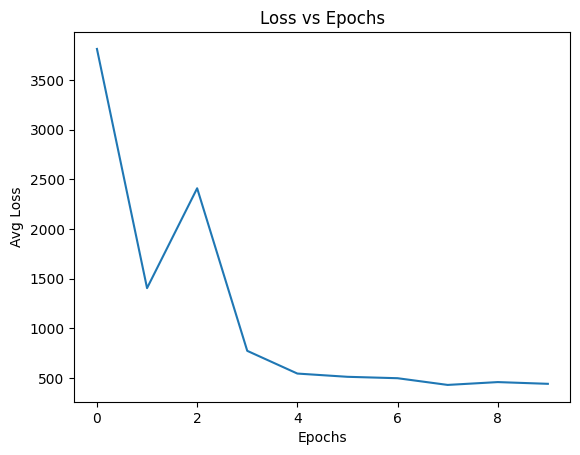

In [ ]:
from tqdm import tqdm
import time
start_time=time.time()
net = FFN().to(device=device)

criterion = torch.nn.MSELoss()
loss_avg=0
loss_list=[]

optimizer = torch.optim.Adam(net.parameters(), lr=4e-3)
NUM_EPOCHS = 10
i=0

for i in range(NUM_EPOCHS):
  print(i)
  loop = tqdm(dataloader, total=len(dataloader), leave=True)
  loss_avg=0
  for batch in loop:
  # for batch in dataloader:
      x, y, actual = batch["x"].to(device=device), batch["y"].to(device=device), batch["intensity"].to(device=device)
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1
      coord=torch.stack((x,y),dim=1)
      pred =net(coord)
      pred=pred.to(device=device)
      loss = criterion(pred.float(), actual.float())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_avg= loss_avg+ loss.item()

  end_time=time.time()- start_time
  net_loss= loss_avg/len(dataloader)
  print("\n",net_loss)
  loss_list.append(net_loss)

plt.plot(loss_list)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Avg Loss")

100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 433.30it/s]


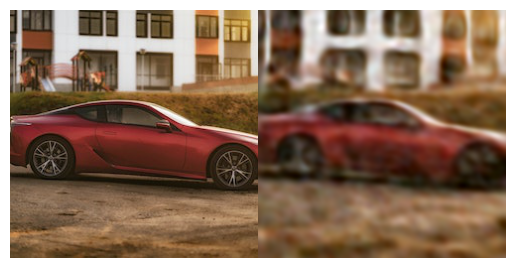

In [ ]:
gt_image= torch.zeros((dataset.h, dataset.w, dataset.num_channels), dtype=torch.uint8)
pred_image= torch.zeros((dataset.h, dataset.w, dataset.num_channels), dtype=torch.uint8)
loop = tqdm(dataloader, total=len(dataloader), leave=True)
for batch in loop:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[y,x] = intensity
    # print(intensity.dtype)
    norm_x = x / dataset.w # normalizing x between 0 and 1
    norm_y = y / dataset.h # normalizing y between 0 and 1
    coord=torch.stack((norm_x,norm_y),dim=1).to(device=device)
    pred =net(coord).to(device=device)
    # print(pred)
    pred=pred.detach().cpu()
    pred=torch.clamp(pred,min=0,max=255)
    pred_image[y,x]= pred.to(torch.uint8)


joint_image = torch.cat([gt_image, pred_image], dim=1)
plt.imshow(joint_image)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio #https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
psnr = PeakSignalNoiseRatio()
psnr=psnr(pred_tensor,gt_tensor)
print(psnr)

tensor(29.8554)

### Attempt Two : Implementing Postional Encoding


In [ ]:
#Referred code from https://github.com/tancik/fourier-feature-networks/tree/master

import numpy as np

embedding =  256
enc_scale =  6

b = 2.**np.linspace(0,enc_scale,embedding//2) - 1
b = np.stack([b, np.zeros_like(b)], -1)
b = np.concatenate([b, np.roll(b, 1, axis=-1)], 0) + 0
a = np.ones((b.shape[0]))

scale=10
y=torch.tensor([])

encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T),
                                                    a * np.cos((2.*np.pi*x) @ b.T)], axis=-1)

true_image=read_image(filepath)

for x_idx in range(true_image.shape[1]):
    for y_idx in range(true_image.shape[2]):
        y= torch.cat((y,image[:, y_idx, x_idx]))

y=y.reshape(250,250,3)
resolution=500
x_grid = np.linspace(0, 1, resolution//2+1)[:-1]
x_train=np.stack(np.meshgrid(x_grid,x_grid), axis=-1)
train_data = (encoder(x_train, a, b*scale))


In [ ]:
#Model inspired by https://github.com/tancik/fourier-feature-networks/tree/master
import torch.nn as nn
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,3),
        nn.Sigmoid()
         )


    def forward(self, coord):
        out = self.layers(coord)
        return out


from tqdm import tqdm
import time
start_time=time.time()
net = FFN().to(device=device)

criterion = torch.nn.MSELoss()
loss_avg=0
loss_list=[]

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
NUM_EPOCHS = 1000
i=0
avg_loss=0


for i in tqdm(range(NUM_EPOCHS)):
    pred=net(torch.tensor(train_data).to(device).to(torch.float32))
    loss = criterion((pred*255).float().cpu(), y.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss=avg_loss+loss.item()

avg_loss=avg_loss/NUM_EPOCHS
print("\n",avg_loss)


100%|██████████| 1000/1000 [03:36<00:00,  4.63it/s]


 528.15023620224


In [ ]:
!pip install  torchmetrics
from torchmetrics.image import PeakSignalNoiseRatio #https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
psnr = PeakSignalNoiseRatio()
psnr=psnr((pred*255).cpu(),y)
print("\n PSNR",psnr)

PSNR tensor(33.7006, grad_fn=<SqueezeBackward0>)


torch.Size([3, 250, 250])


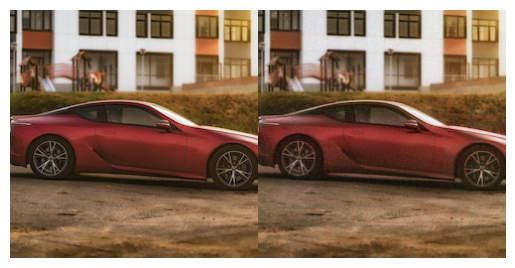

In [ ]:
o_p_img=torch.zeros((dataset.h, dataset.w, dataset.num_channels), dtype=torch.uint8)
for x_idx in range(image.shape[1]):
    for y_idx in range(image.shape[2]):
        o_p_img[y_idx,x_idx]=(pred[y_idx,x_idx,:]*255).cpu()


joint_image = torch.cat([gt_image, o_p_img.permute(1,0,2)], dim=1)
plt.imshow(joint_image)
print(image.shape)
plt.axis('off')
plt.show()
plt.close()

### **References**
For sin activation function:
https://discuss.pytorch.org/t/sine-activation-missing-in-pytorch-nn/189470/5
Pytorch does not have a native sin activation function implementation.

For Postional Encoding,
the Paper [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://arxiv.org/pdf/2006.10739.pdf) and the [code](https://github.com/tancik/fourier-feature-networks/tree/master) provided by the authors publically inspired the implementation of the same above.